<a href="https://colab.research.google.com/github/xander-bennett/DS-Unit-2-Regression-Classification/blob/master/module2/Xander_Bennett_DS7_assignment_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Do the [Plotly Dash](https://dash.plot.ly/) Tutorial, Parts 1 & 2.
- [ ] Add your own stretch goal(s) !

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [4]:
df.dtypes

bathrooms               float64
bedrooms                  int64
created                  object
description              object
display_address          object
latitude                float64
longitude               float64
price                     int64
street_address           object
interest_level           object
elevator                  int64
cats_allowed              int64
hardwood_floors           int64
dogs_allowed              int64
doorman                   int64
dishwasher                int64
no_fee                    int64
laundry_in_building       int64
fitness_center            int64
pre-war                   int64
laundry_in_unit           int64
roof_deck                 int64
outdoor_space             int64
dining_room               int64
high_speed_internet       int64
balcony                   int64
swimming_pool             int64
new_construction          int64
terrace                   int64
exclusive                 int64
loft                      int64
garden_p

In [5]:
# Created is not in datetime format. adjusting.
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)

df['created'].head()

0   2016-06-24 07:54:24
1   2016-06-12 12:19:27
2   2016-04-17 03:26:41
3   2016-04-18 02:22:02
4   2016-04-28 01:32:41
Name: created, dtype: datetime64[ns]

In [6]:
df['all_animals'] = (df['cats_allowed'] == 1) & (df['dogs_allowed'] == 1)

df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,all_animals
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False


In [7]:
df['bed/bath_ratio'] = df['bathrooms'] / df['bedrooms']

df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,all_animals,bed/bath_ratio
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.50
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,0.50
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1.00
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1.00
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.25


In [8]:
df.shape

(48817, 36)

In [9]:
# Infinite values are due to apartments that don't have a bedroom. Such as studios. Removing these from the data set.

df['bed/bath_ratio'].value_counts()

1.000000    19014
0.500000    12240
inf          9166
0.333333     3603
0.666667     2772
0.250000      366
0.750000      343
2.000000      206
1.500000      188
0.000000      153
0.400000      129
0.833333      128
1.250000       83
0.375000       61
0.625000       38
0.600000       35
0.800000       31
0.875000       27
1.166667       24
3.000000       14
1.333333       12
0.200000       10
1.125000        7
0.300000        5
0.700000        3
2.500000        2
1.750000        1
0.416667        1
4.500000        1
5.000000        1
0.166667        1
0.428571        1
Name: bed/bath_ratio, dtype: int64

In [10]:
df = df.replace([np.inf, -np.inf], np.nan)
df['bed/bath_ratio'].isnull().sum()


9317

In [11]:
# Dropping all null, infinity values
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df['bed/bath_ratio'].isnull().sum()

0

In [12]:
# Adding description length
df['description_length'] = df['description'].apply(len)
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,all_animals,bed/bath_ratio,description_length
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.50,588
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,0.50,8
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1.00,691
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1.00,492
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.25,479


In [13]:
df['description_length'].isnull().sum()

0

In [0]:
# This was one way to split the train and test data based off of date
# start_date = '2016-06-01'
# end_date = '2016-06-31'

# mask = (df['created'] > start_date) & (df['created'] <= end_date)

In [0]:
df.created=pd.to_datetime(df['created'], infer_datetime_format=True)
df['created'][0].date()
def extractMonth(date):
  return date.month

In [0]:
df['monthCreated']=df['created'].apply(extractMonth)

In [17]:
# Adding description length
df['description_length'] = df['description'].apply(len)
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,all_animals,bed/bath_ratio,description_length,monthCreated
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.50,588,6
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,0.50,8,6
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1.00,691,4
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1.00,492,4
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.25,479,4


In [0]:
train = df[df['monthCreated'] != 6]
test = df[df['monthCreated'] == 6]

In [19]:
# Now for the linear regression. This will be done on multiple features, whereas a simple linear regression is done using just one feature

# Importing the appropriate estimator class
from sklearn.linear_model import LinearRegression

# Instantiate the class
model = LinearRegression()

# Arrange X features matrix and y target vector

features = [
            'description_length',
            'bed/bath_ratio'
            ]

target = 'price'

X = df[features]
y = df[target]

# Fit the model
model.fit(X,y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
model.intercept_, model.coef_

(3303.0339144572185, array([ 0.80565763, 32.97010141]))

In [21]:
# This is easier to read
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())


Intercept 3303.0339144572185
description_length     0.805658
bed/bath_ratio        32.970101


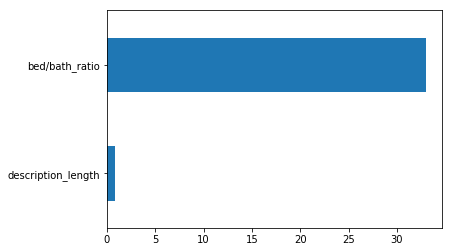

In [22]:
# Plot coefficients
%matplotlib inline
coefficients.sort_values().plot.barh();

In [23]:
# Note that the features are on different scales,
# So the coefficiencts are on different scales, too
df[features].describe()

,description_length,bed/bath_ratio
count,38257.000000,38257.000000
mean,631.573490,0.750163
std,384.752584,0.292299
min,1.000000,0.000000
25%,373.000000,0.500000
50%,590.000000,0.750000
75%,833.000000,1.000000
max,4466.000000,5.000000


In [24]:
# Now to use regression metrics:MAE (Mean absolute error) and R**2 score

# Apply the model
y_pred = model.predict(X)
df['predicted'] = y_pred
df['error'] = y_pred - y

df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,all_animals,bed/bath_ratio,description_length,monthCreated,predicted,error
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.50,588,6,3793.245649,793.245649
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,0.50,8,6,3325.964226,-2139.035774
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1.00,691,4,3892.713435,1042.713435
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1.00,492,4,3732.387568,457.387568
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.25,479,4,3697.186442,347.186442


In [25]:
df['error'].abs().mean()

1247.7431180717342

In [26]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y, y_pred)

1247.7431180717376

In [27]:
y.mean()

3836.5988707948873

In [28]:
guesses= [y.mean()] * len(y)
mean_absolute_error(y, guesses)

1264.038577690124

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

def regression_residuals(df, feature, target, m, b):
    """
    Visualize linear regression, with residual errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    df.plot.scatter(feature, target)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    plt.plot(x, y_pred)
    
    # Plot residual errors
    for x, y1, y2 in zip(x, y, y_pred):
        plt.plot((x, x), (y1, y2), color='grey')
    
    # Print regression metrics
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

In [0]:
feature = 'description_length'
regression_residuals(df, feature, target, m=0, b=y.mean())